# RANSAC-based Independent Motion Detection

This notebook implements motion detection for moving cameras using RANSAC outlier detection.

**Key insight**: Camera motion affects all scene points in a geometrically consistent way (homography/affine transform). Objects moving independently violate this geometric consistency and appear as **outliers** in the dominant motion model.

## Pipeline:
1. Track features with Lucas-Kanade optical flow
2. Fit homography using RANSAC → outliers = moving object candidates
3. Warp previous frame using estimated transform
4. Compute residual = |current - warped_previous|
5. Adaptive threshold using MAD (Median Absolute Deviation)
6. Morphological cleanup
7. Connected components → bounding boxes

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
# Configuration
VIDEO_PATH = 'data/videos/test_video_3.mp4'
OUTPUT_DIR = 'data/ransac_motion_frames'
OUTLIERS_DIR = 'data/ransac_outliers_frames'
RESIDUAL_DIR = 'data/ransac_residual_frames'

# Create output directories
for dir_path in [OUTPUT_DIR, OUTLIERS_DIR, RESIDUAL_DIR]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

# Feature detection parameters (Shi-Tomasi)
feature_params = dict(
    maxCorners=200,
    qualityLevel=0.01,
    minDistance=30,
    blockSize=7
)

# Lucas-Kanade optical flow parameters
lk_params = dict(
    winSize=(21, 21),
    maxLevel=3,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
)

# RANSAC parameters
RANSAC_REPROJ_THRESHOLD = 3.0  # Pixels - points with higher error are outliers

# Motion detection parameters
RESIDUAL_THRESHOLD_SIGMA = 3.0  # MAD-based threshold multiplier
MIN_OBJECT_AREA = 500  # Minimum pixels for valid detection
MAX_OBJECT_AREA = 50000  # Maximum pixels for valid detection

# Sampling
FRAME_SAMPLE_INTERVAL = 5

In [3]:
def detect_features(gray):
    """Detect Shi-Tomasi features for tracking."""
    pts = cv2.goodFeaturesToTrack(gray, **feature_params)
    return pts


def track_features(prev_gray, curr_gray, prev_pts):
    """Track features using Lucas-Kanade optical flow."""
    if prev_pts is None or len(prev_pts) == 0:
        return None, None, None
    
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(
        prev_gray, curr_gray, prev_pts, None, **lk_params
    )
    
    # Filter valid points
    if status is not None:
        good_old = prev_pts[status.ravel() == 1]
        good_new = curr_pts[status.ravel() == 1]
        return good_old, good_new, status
    
    return None, None, None


def estimate_ego_motion_ransac(old_pts, new_pts, method='homography'):
    """
    Estimate camera ego-motion using RANSAC.
    Returns transform matrix and inlier mask.
    Outliers (inlier_mask == 0) are moving object candidates.
    """
    if old_pts is None or len(old_pts) < 4:
        return None, None
    
    if method == 'homography':
        # Full homography (8 DOF) - best for planar scenes
        H, inlier_mask = cv2.findHomography(
            old_pts, new_pts, cv2.RANSAC, RANSAC_REPROJ_THRESHOLD
        )
        return H, inlier_mask
    
    elif method == 'affine':
        # Full affine (6 DOF)
        H, inlier_mask = cv2.estimateAffine2D(
            old_pts, new_pts, method=cv2.RANSAC, 
            ransacReprojThreshold=RANSAC_REPROJ_THRESHOLD
        )
        return H, inlier_mask
    
    elif method == 'similarity':
        # Similarity transform (4 DOF) - rotation, scale, translation
        H, inlier_mask = cv2.estimateAffinePartial2D(
            old_pts, new_pts, method=cv2.RANSAC,
            ransacReprojThreshold=RANSAC_REPROJ_THRESHOLD
        )
        return H, inlier_mask
    
    return None, None


def warp_frame(frame, H, method='homography'):
    """Warp frame using estimated transform."""
    h, w = frame.shape[:2]
    
    if method == 'homography':
        warped = cv2.warpPerspective(frame, H, (w, h))
    else:
        # Affine or similarity
        warped = cv2.warpAffine(frame, H, (w, h))
    
    return warped


def compute_residual(curr_gray, warped_prev_gray):
    """Compute residual motion after ego-motion compensation."""
    residual = cv2.absdiff(curr_gray, warped_prev_gray)
    return residual


def adaptive_threshold_mad(residual, sigma_multiplier=3.0):
    """
    Adaptive thresholding using Median Absolute Deviation (MAD).
    MAD is robust to outliers unlike standard deviation.
    """
    median_val = np.median(residual)
    mad = np.median(np.abs(residual.astype(np.float32) - median_val))
    # Scale MAD to standard deviation equivalent
    mad_std = mad * 1.4826
    
    threshold = median_val + sigma_multiplier * mad_std
    threshold = max(threshold, 15)  # Minimum threshold to avoid noise
    
    _, motion_mask = cv2.threshold(
        residual, threshold, 255, cv2.THRESH_BINARY
    )
    
    return motion_mask.astype(np.uint8), threshold


def morphological_cleanup(mask):
    """Apply morphological operations to clean up motion mask."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Close - fill small holes
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    # Open - remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask


def extract_bounding_boxes(mask, min_area=500, max_area=50000):
    """
    Extract bounding boxes from motion mask using connected components.
    """
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    
    detections = []
    for i in range(1, num_labels):  # Skip background (label 0)
        area = stats[i, cv2.CC_STAT_AREA]
        
        if min_area < area < max_area:
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            centroid = tuple(map(int, centroids[i]))
            
            detections.append({
                'bbox': (x, y, w, h),
                'centroid': centroid,
                'area': area
            })
    
    return detections


def draw_detections(frame, detections, outlier_pts=None):
    """Draw bounding boxes and outlier points on frame."""
    output = frame.copy()
    
    # Draw bounding boxes
    for det in detections:
        x, y, w, h = det['bbox']
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.circle(output, det['centroid'], 5, (0, 0, 255), -1)
        cv2.putText(output, f"Area: {det['area']}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Draw outlier points (RANSAC outliers = moving candidates)
    if outlier_pts is not None:
        for pt in outlier_pts:
            cv2.circle(output, tuple(map(int, pt.ravel())), 5, (255, 0, 0), -1)
    
    return output


def draw_tracked_points(frame, old_pts, new_pts, inlier_mask):
    """Draw tracked points with different colors for inliers/outliers."""
    output = frame.copy()
    
    if old_pts is None or inlier_mask is None:
        return output
    
    for i, (old, new) in enumerate(zip(old_pts, new_pts)):
        old_pt = tuple(map(int, old.ravel()))
        new_pt = tuple(map(int, new.ravel()))
        
        if inlier_mask[i] == 1:
            # Inlier - follows camera motion (green)
            color = (0, 255, 0)
        else:
            # Outlier - independent motion (red)
            color = (0, 0, 255)
        
        cv2.circle(output, new_pt, 5, color, -1)
        cv2.line(output, old_pt, new_pt, color, 2)
    
    return output

In [4]:
def process_video_ransac(video_path, method='homography'):
    """
    Main processing pipeline using RANSAC-based motion detection.
    
    Args:
        video_path: Path to input video
        method: 'homography', 'affine', or 'similarity'
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return
    
    ret, prev_frame = cap.read()
    if not ret:
        print("Error: Cannot read first frame")
        return
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    prev_pts = detect_features(prev_gray)
    
    frame_count = 0
    saved_count = 0
    
    print(f"Processing video with {method} transform...")
    print(f"RANSAC reprojection threshold: {RANSAC_REPROJ_THRESHOLD} pixels")
    
    while True:
        ret, curr_frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
        
        # Track features
        old_pts, new_pts, status = track_features(prev_gray, curr_gray, prev_pts)
        
        if old_pts is not None and len(old_pts) >= 4:
            # Estimate ego-motion with RANSAC
            H, inlier_mask = estimate_ego_motion_ransac(old_pts, new_pts, method)
            
            if H is not None and inlier_mask is not None:
                # Get outlier points (moving object candidates)
                outlier_mask = inlier_mask.ravel() == 0
                outlier_pts = new_pts[outlier_mask] if np.any(outlier_mask) else None
                num_outliers = np.sum(outlier_mask)
                num_inliers = np.sum(inlier_mask)
                
                # Warp previous frame to align with current
                warped_prev_gray = warp_frame(prev_gray, H, method)
                
                # Compute residual (what's left after compensation)
                residual = compute_residual(curr_gray, warped_prev_gray)
                
                # Adaptive threshold
                motion_mask, thresh_val = adaptive_threshold_mad(
                    residual, RESIDUAL_THRESHOLD_SIGMA
                )
                
                # Morphological cleanup
                motion_mask = morphological_cleanup(motion_mask)
                
                # Extract detections
                detections = extract_bounding_boxes(
                    motion_mask, MIN_OBJECT_AREA, MAX_OBJECT_AREA
                )
                
                # Save frames at intervals
                if frame_count % FRAME_SAMPLE_INTERVAL == 0:
                    # Draw results
                    output_frame = draw_detections(curr_frame, detections, outlier_pts)
                    outliers_frame = draw_tracked_points(
                        curr_frame, old_pts, new_pts, inlier_mask.ravel()
                    )
                    
                    # Save frames
                    cv2.imwrite(
                        f"{OUTPUT_DIR}/frame_{saved_count:04d}.png",
                        output_frame
                    )
                    cv2.imwrite(
                        f"{OUTLIERS_DIR}/frame_{saved_count:04d}.png",
                        outliers_frame
                    )
                    cv2.imwrite(
                        f"{RESIDUAL_DIR}/frame_{saved_count:04d}.png",
                        residual
                    )
                    
                    print(f"Frame {frame_count}: {num_inliers} inliers, "
                          f"{num_outliers} outliers, {len(detections)} detections, "
                          f"threshold={thresh_val:.1f}")
                    saved_count += 1
        
        # Re-detect features periodically or when too few remain
        if frame_count % 10 == 0 or (new_pts is not None and len(new_pts) < 50):
            prev_pts = detect_features(curr_gray)
        else:
            prev_pts = new_pts.reshape(-1, 1, 2) if new_pts is not None else detect_features(curr_gray)
        
        prev_gray = curr_gray.copy()
    
    cap.release()
    print(f"\nProcessing complete. Saved {saved_count} frames.")
    print(f"Outputs saved to: {OUTPUT_DIR}, {OUTLIERS_DIR}, {RESIDUAL_DIR}")

In [5]:
# Run with homography transform (best for planar scenes)
process_video_ransac(VIDEO_PATH, method='homography')

Processing video with homography transform...
RANSAC reprojection threshold: 3.0 pixels
Frame 5: 197 inliers, 3 outliers, 0 detections, threshold=15.0
Frame 10: 200 inliers, 0 outliers, 0 detections, threshold=15.0
Frame 15: 200 inliers, 0 outliers, 0 detections, threshold=15.0
Frame 20: 200 inliers, 0 outliers, 2 detections, threshold=15.0
Frame 25: 200 inliers, 0 outliers, 0 detections, threshold=15.0
Frame 30: 200 inliers, 0 outliers, 2 detections, threshold=15.0
Frame 35: 200 inliers, 0 outliers, 2 detections, threshold=15.0
Frame 40: 200 inliers, 0 outliers, 2 detections, threshold=15.0
Frame 45: 200 inliers, 0 outliers, 6 detections, threshold=15.0
Frame 50: 198 inliers, 0 outliers, 0 detections, threshold=15.0
Frame 55: 200 inliers, 0 outliers, 1 detections, threshold=15.0
Frame 60: 198 inliers, 0 outliers, 0 detections, threshold=15.0
Frame 65: 195 inliers, 0 outliers, 0 detections, threshold=15.0
Frame 70: 194 inliers, 1 outliers, 3 detections, threshold=15.0
Frame 75: 28 inli

Found 151 output frames


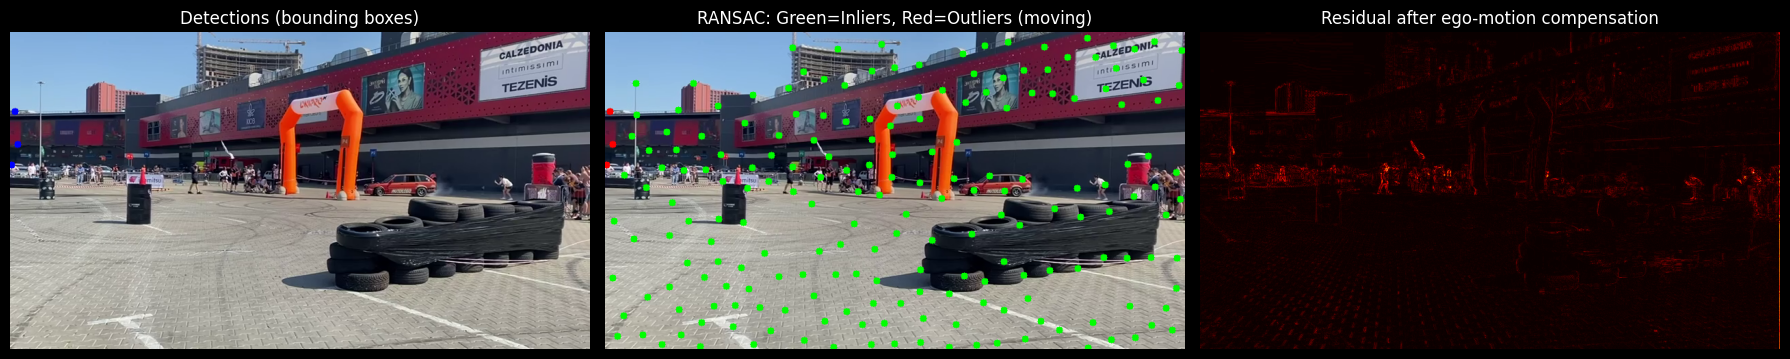

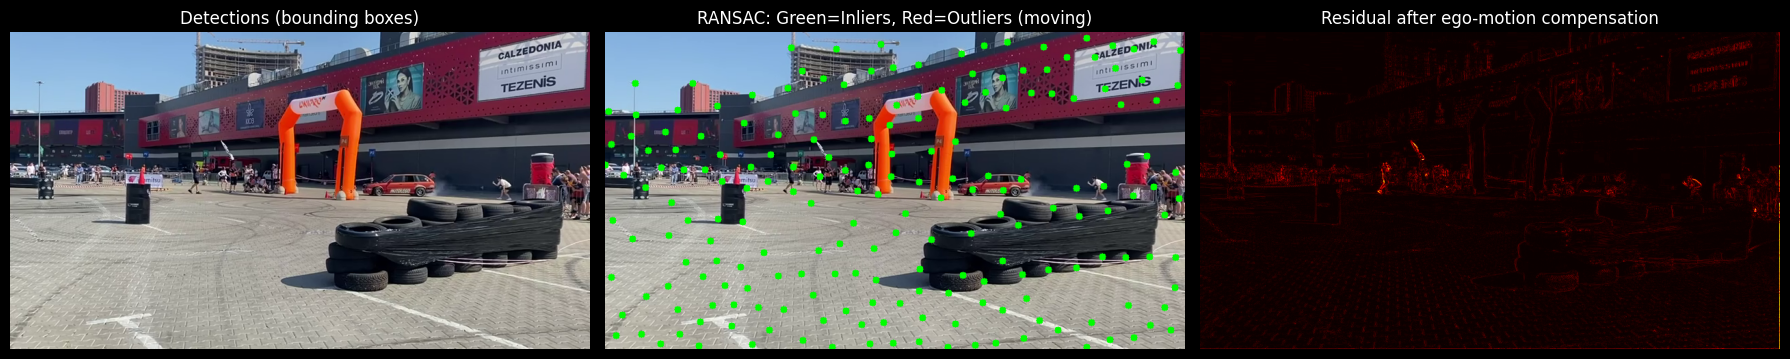

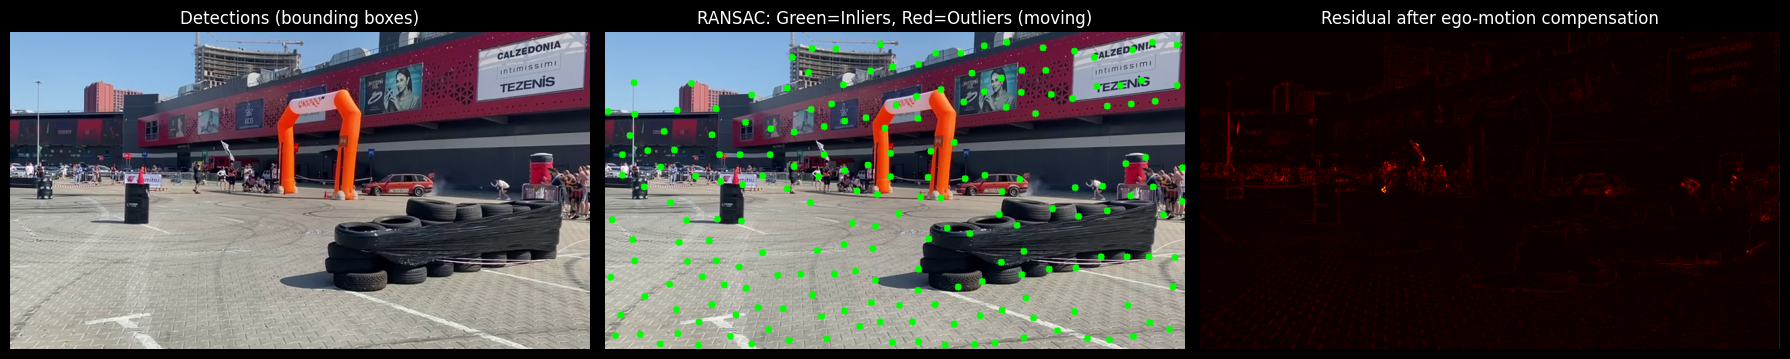

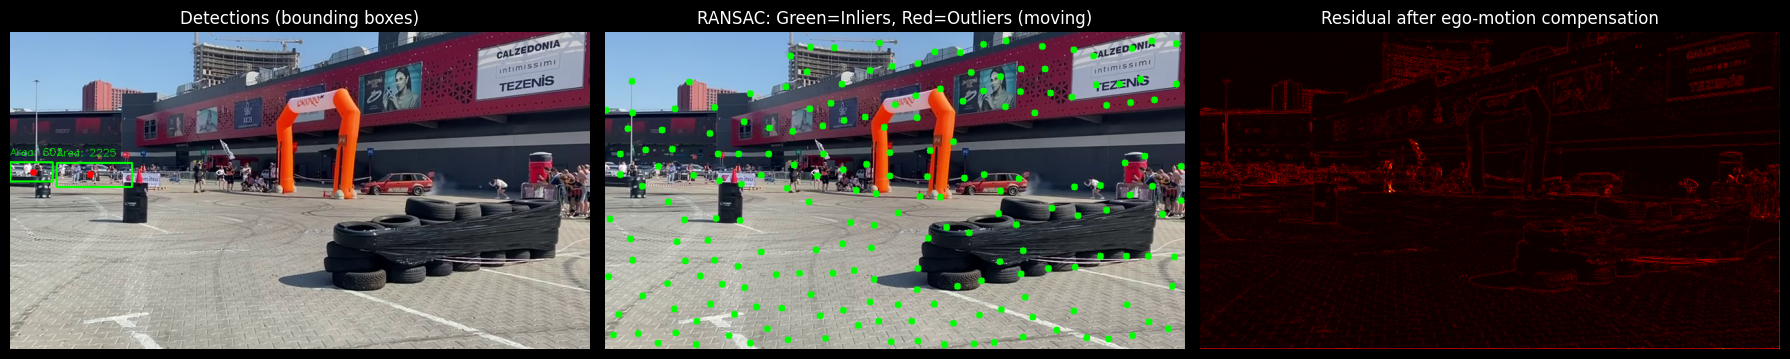

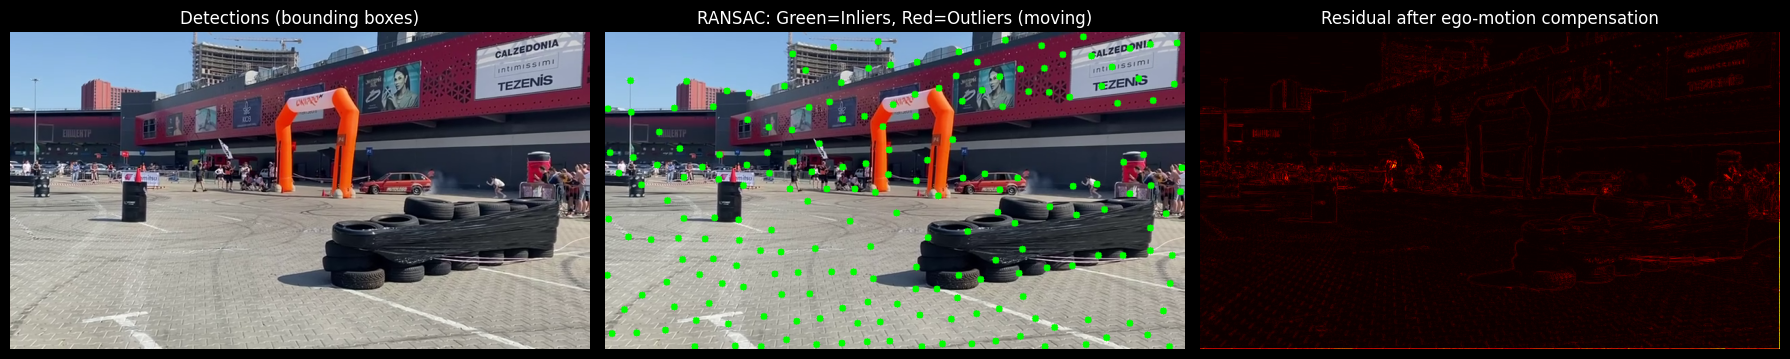

In [6]:
# Visualize sample results
import glob

def show_results(frame_idx=0):
    """Display detection, outliers, and residual for a specific frame."""
    detection_path = f"{OUTPUT_DIR}/frame_{frame_idx:04d}.png"
    outliers_path = f"{OUTLIERS_DIR}/frame_{frame_idx:04d}.png"
    residual_path = f"{RESIDUAL_DIR}/frame_{frame_idx:04d}.png"
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    if os.path.exists(detection_path):
        detection = cv2.imread(detection_path)
        axes[0].imshow(cv2.cvtColor(detection, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Detections (bounding boxes)')
    axes[0].axis('off')
    
    if os.path.exists(outliers_path):
        outliers = cv2.imread(outliers_path)
        axes[1].imshow(cv2.cvtColor(outliers, cv2.COLOR_BGR2RGB))
        axes[1].set_title('RANSAC: Green=Inliers, Red=Outliers (moving)')
    axes[1].axis('off')
    
    if os.path.exists(residual_path):
        residual = cv2.imread(residual_path, cv2.IMREAD_GRAYSCALE)
        axes[2].imshow(residual, cmap='hot')
        axes[2].set_title('Residual after ego-motion compensation')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show first few results
output_files = sorted(glob.glob(f"{OUTPUT_DIR}/frame_*.png"))
print(f"Found {len(output_files)} output frames")

for i in range(min(5, len(output_files))):
    show_results(i)

## Compare Different Transform Methods

Let's compare homography, affine, and similarity transforms to see which works best for your video.

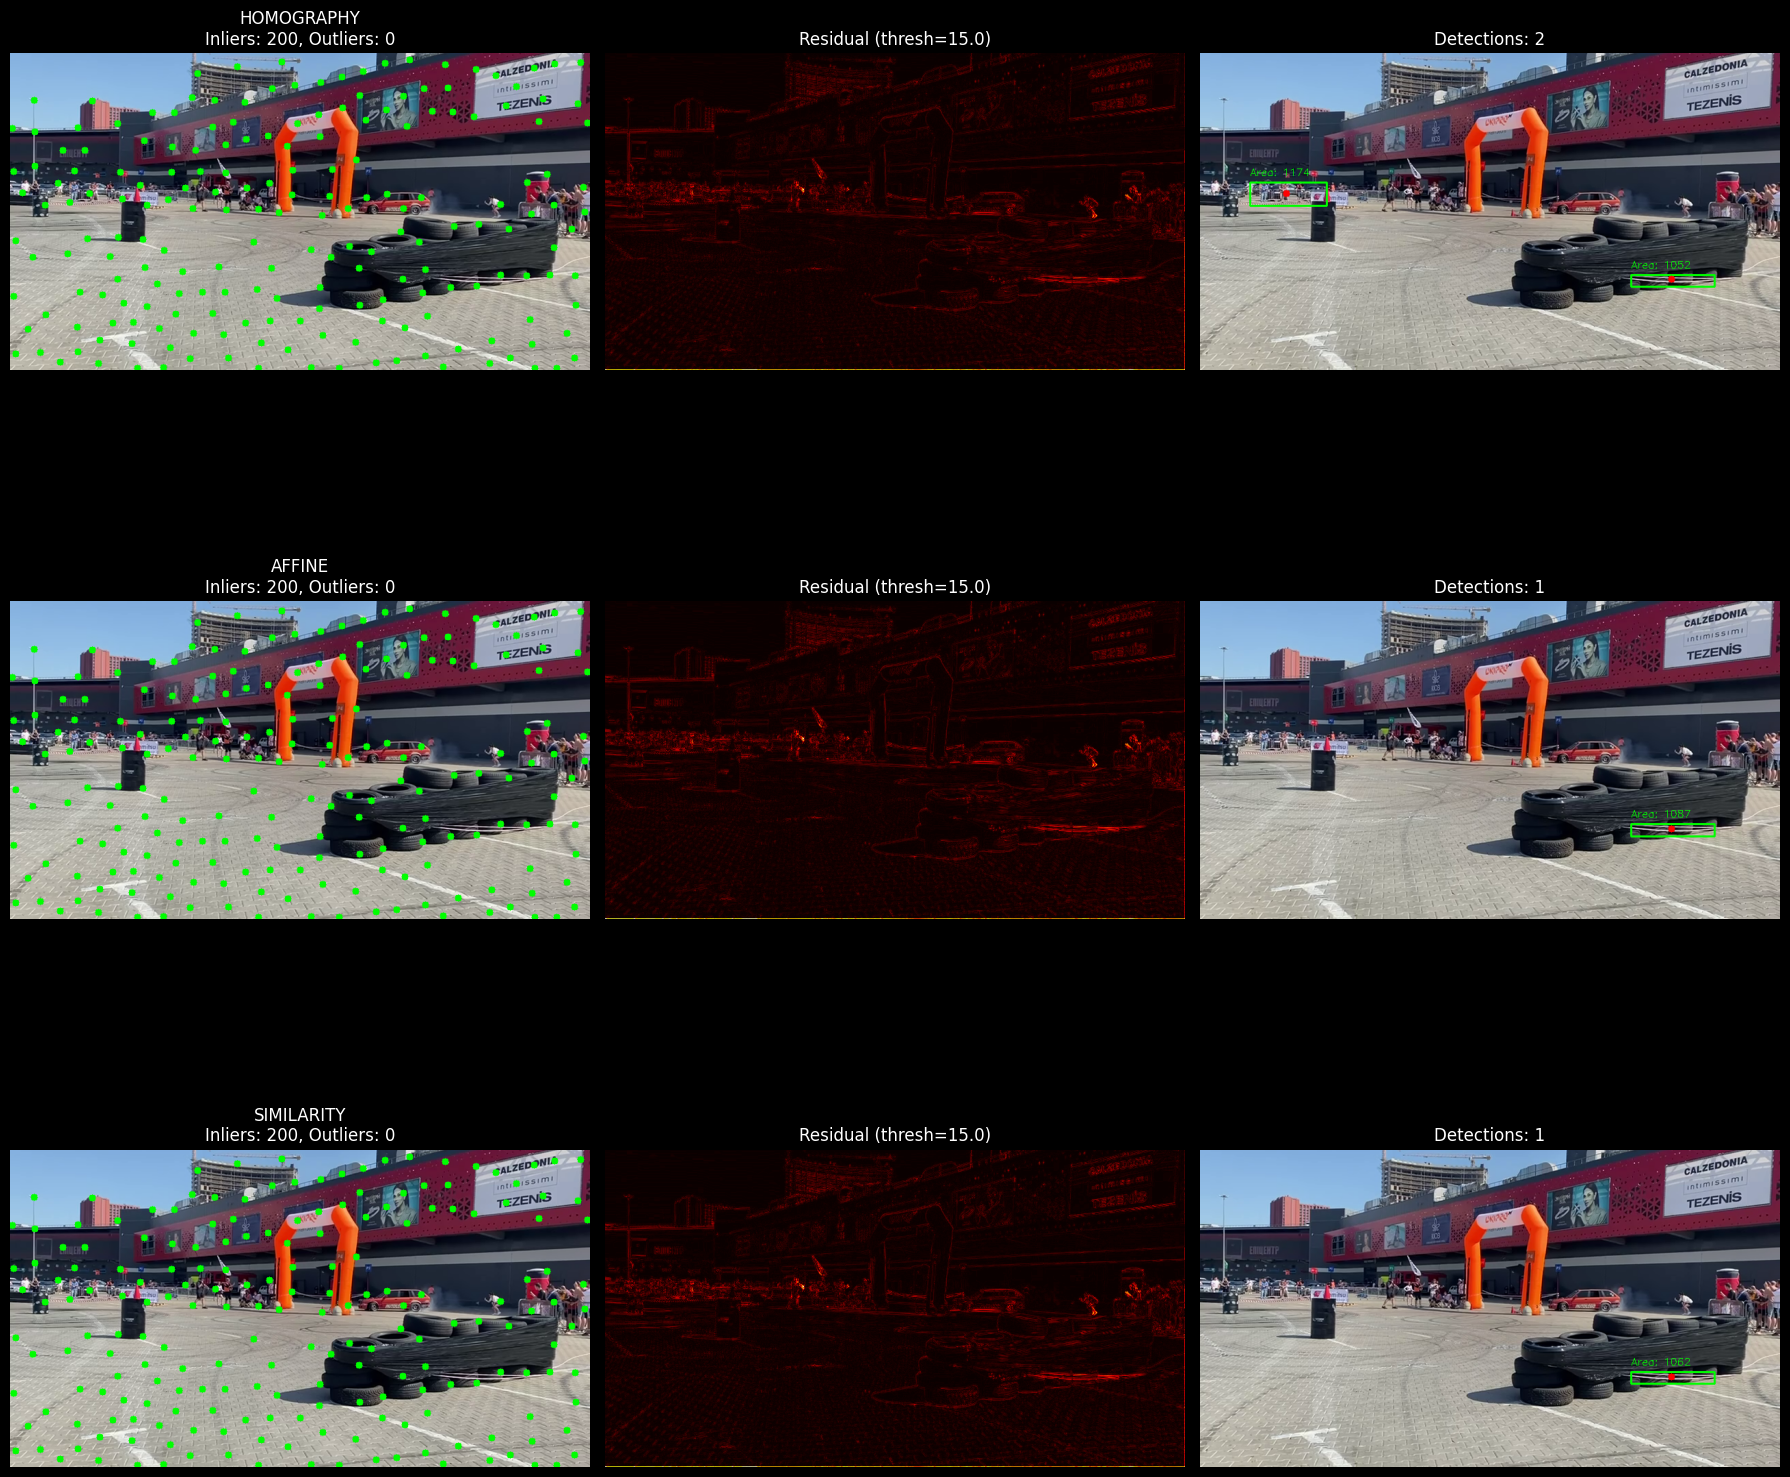

Comparison saved to data/ransac_method_comparison.png


In [7]:
def compare_single_frame(video_path, frame_num=30):
    """Compare all three methods on a single frame."""
    cap = cv2.VideoCapture(video_path)
    
    # Skip to frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
    ret, prev_frame = cap.read()
    ret, curr_frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Cannot read frame {frame_num}")
        return
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    # Detect and track features
    prev_pts = detect_features(prev_gray)
    old_pts, new_pts, _ = track_features(prev_gray, curr_gray, prev_pts)
    
    if old_pts is None or len(old_pts) < 4:
        print("Not enough tracked points")
        return
    
    methods = ['homography', 'affine', 'similarity']
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    
    for row, method in enumerate(methods):
        H, inlier_mask = estimate_ego_motion_ransac(old_pts, new_pts, method)
        
        if H is None:
            continue
        
        num_outliers = np.sum(inlier_mask.ravel() == 0)
        num_inliers = np.sum(inlier_mask.ravel() == 1)
        
        # Warp and compute residual
        warped_prev = warp_frame(prev_gray, H, method)
        residual = compute_residual(curr_gray, warped_prev)
        motion_mask, thresh = adaptive_threshold_mad(residual, RESIDUAL_THRESHOLD_SIGMA)
        motion_mask = morphological_cleanup(motion_mask)
        
        # Draw results
        outliers_vis = draw_tracked_points(
            curr_frame, old_pts, new_pts, inlier_mask.ravel()
        )
        
        detections = extract_bounding_boxes(motion_mask, MIN_OBJECT_AREA, MAX_OBJECT_AREA)
        detection_vis = draw_detections(curr_frame, detections)
        
        # Plot
        axes[row, 0].imshow(cv2.cvtColor(outliers_vis, cv2.COLOR_BGR2RGB))
        axes[row, 0].set_title(f"{method.upper()}\nInliers: {num_inliers}, Outliers: {num_outliers}")
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(residual, cmap='hot')
        axes[row, 1].set_title(f"Residual (thresh={thresh:.1f})")
        axes[row, 1].axis('off')
        
        axes[row, 2].imshow(cv2.cvtColor(detection_vis, cv2.COLOR_BGR2RGB))
        axes[row, 2].set_title(f"Detections: {len(detections)}")
        axes[row, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('data/ransac_method_comparison.png', dpi=150)
    plt.show()
    print("Comparison saved to data/ransac_method_comparison.png")

compare_single_frame(VIDEO_PATH, frame_num=30)

## Parameter Tuning

Key parameters to adjust:

1. **RANSAC_REPROJ_THRESHOLD** (default: 3.0 pixels)
   - Lower (1-2): More sensitive, detects subtle motion but more false positives
   - Higher (5-10): Less sensitive, only strong motion detected

2. **RESIDUAL_THRESHOLD_SIGMA** (default: 3.0)
   - Lower (2.0): More sensitive to residual differences
   - Higher (4-5): Only strong residuals trigger detection

3. **MIN_OBJECT_AREA / MAX_OBJECT_AREA**
   - Adjust based on expected object sizes in your video

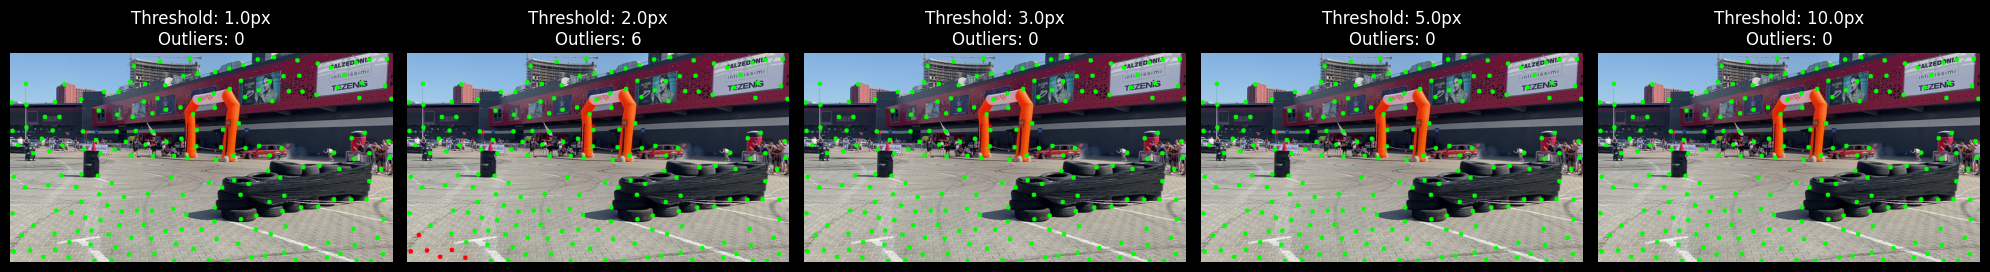

In [8]:
def test_ransac_thresholds(video_path, frame_num=30, thresholds=[1.0, 2.0, 3.0, 5.0, 10.0]):
    """Test different RANSAC reprojection thresholds."""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num - 1)
    ret, prev_frame = cap.read()
    ret, curr_frame = cap.read()
    cap.release()
    
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)
    
    prev_pts = detect_features(prev_gray)
    old_pts, new_pts, _ = track_features(prev_gray, curr_gray, prev_pts)
    
    fig, axes = plt.subplots(1, len(thresholds), figsize=(4*len(thresholds), 4))
    
    for i, thresh in enumerate(thresholds):
        H, inlier_mask = cv2.findHomography(
            old_pts, new_pts, cv2.RANSAC, thresh
        )
        
        if H is not None:
            num_outliers = np.sum(inlier_mask.ravel() == 0)
            outliers_vis = draw_tracked_points(
                curr_frame, old_pts, new_pts, inlier_mask.ravel()
            )
            axes[i].imshow(cv2.cvtColor(outliers_vis, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"Threshold: {thresh}px\nOutliers: {num_outliers}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('data/ransac_threshold_comparison.png', dpi=150)
    plt.show()

test_ransac_thresholds(VIDEO_PATH)

## Understanding the Results

### RANSAC Outliers Visualization
- **Green points**: Inliers - these points follow the estimated camera motion model
- **Red points**: Outliers - these points don't fit the camera motion, indicating independent movement

### Residual Image
- Bright areas show motion that wasn't explained by the camera transform
- This should highlight independently moving objects
- If the entire image is bright, the camera motion estimation may be poor

### Common Issues
1. **Too many outliers everywhere**: Lower the RANSAC threshold or use a simpler transform model
2. **No outliers detected**: Increase RANSAC threshold or the object isn't moving enough
3. **Residual shows edges/parallax**: This is depth-dependent motion from camera translation - harder to handle, may need depth estimation
4. **Black borders in warped frame**: This happens at image edges - can be masked out